In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os
import cv2
from PIL import Image

from glob import glob
from tqdm import tqdm

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

C:\Users\jeffg\AppData\Local\Temp\ipykernel_45072\1379983671.py:19: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# RAF
```
Notes:
1: Surprise
2: Fear
3: Disgust
4: Happiness
5: Sadness
6: Anger
7: Neutral
```

In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


dataset_path = r"C:\Users\jeffg\face-project\dataset\emotion-RAF"

train_datasets = datasets.ImageFolder(os.path.join(dataset_path, 'train'), transforms_train)
val_datasets = datasets.ImageFolder(os.path.join(dataset_path, 'test'), transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=16, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_datasets))
print('Validation dataset size:', len(val_datasets))

class_names = train_datasets.classes
print('Class names:', class_names)

Train dataset size: 12271
Validation dataset size: 3068
Class names: ['1', '2', '3', '4', '5', '6', '7']


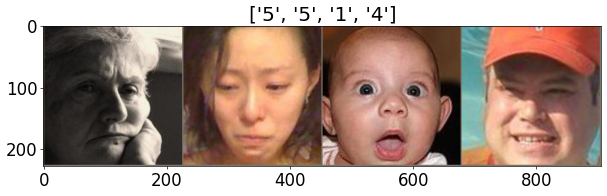

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [5]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names)) # binary classification (num_of_class == 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [6]:
num_epochs = 20
start_time = time.time()
best_accuracy = 0.00001
save_model_name = 'face_emotion_ResNet18.pth'

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    train_acc_list.append(epoch_acc)
    train_loss_list.append(epoch_loss)
    
    
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Validation Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_datasets)
        epoch_acc = running_corrects / len(val_datasets) * 100.

        val_acc_list.append(epoch_acc)
        val_loss_list.append(epoch_loss)
    
        if epoch_acc > best_accuracy:
            torch.save(model, f"best-{save_model_name}")
             
        print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

[Train #0] Loss: 1.0089 Acc: 63.8090% Time: 45.7681s
[Validation #0] Loss: 0.6616 Acc: 76.5319% Time: 65.1072s
[Train #1] Loss: 0.6241 Acc: 78.4207% Time: 106.9242s
[Validation #1] Loss: 0.5298 Acc: 81.0300% Time: 121.8739s
[Train #2] Loss: 0.4727 Acc: 83.3591% Time: 164.8483s
[Validation #2] Loss: 0.5154 Acc: 82.2360% Time: 180.9499s
[Train #3] Loss: 0.3777 Acc: 86.7655% Time: 220.5759s
[Validation #3] Loss: 0.5243 Acc: 82.4641% Time: 234.8696s
[Train #4] Loss: 0.2889 Acc: 90.1882% Time: 272.9312s
[Validation #4] Loss: 0.5043 Acc: 83.5398% Time: 287.2062s
[Train #5] Loss: 0.2134 Acc: 92.8449% Time: 325.6251s
[Validation #5] Loss: 0.5422 Acc: 83.4420% Time: 340.1230s
[Train #6] Loss: 0.1858 Acc: 93.4806% Time: 378.4355s
[Validation #6] Loss: 0.5228 Acc: 83.4746% Time: 392.9561s
[Train #7] Loss: 0.1359 Acc: 95.1838% Time: 431.4437s
[Validation #7] Loss: 0.5352 Acc: 83.9961% Time: 445.9584s
[Train #8] Loss: 0.1095 Acc: 96.3002% Time: 484.2540s
[Validation #8] Loss: 0.5414 Acc: 84.1917% T

In [7]:
# torch.save(model.state_dict(), save_path)
torch.save(model, save_model_name)

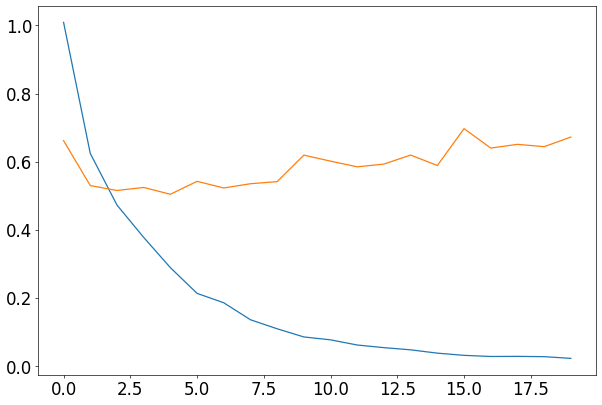

In [8]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)

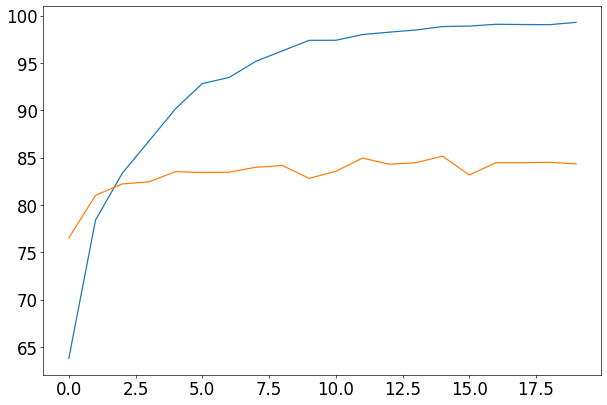

In [9]:
plt.plot([d.cpu().numpy().item() for d in train_acc_list])
plt.plot([d.cpu().numpy().item() for d in val_acc_list])

# test model

In [12]:
now_path = os.getcwd()
os.chdir(r"..")
import __init__
from faceapi import FaceAPIManager
face_api_manager = FaceAPIManager(
    detector_model_path=r'C:\Users\jeffg\face-project\face-api\model_weights\face-yolov8-m.pt',
    encoder_model_path=r'C:\Users\jeffg\face-project\face-api\model_weights\feifei_face.pt',
    emotion_model_path=r"C:\Users\jeffg\face-project\face-api\model_weights\face-emotion.pth",
    
    age_proto_path = r'C:\Users\jeffg\face-project\face-api\model_weights\age_gender_models\age_detector\age_deploy.prototxt', 
    age_model_path = r'C:\Users\jeffg\face-project\face-api\model_weights\age_gender_models\age_detector\age_net.caffemodel', 
    gender_proto_path = r'C:\Users\jeffg\face-project\face-api\model_weights\age_gender_models\gender_detector\gender_deploy.prototxt', 
    gender_model_path = r'C:\Users\jeffg\face-project\face-api\model_weights\age_gender_models\gender_detector\gender_net.caffemodel', 

    device='cuda'
)
os.chdir(now_path)

loaded finetune model , output to 8


In [13]:
save_model_name = 'face_emotion_ResNet18.pth'
# save_model_name = 'face_age_vgg16.pth'

In [14]:
model = torch.load(save_model_name)

In [15]:
# model = models.resnet18(pretrained=True)
# num_features = model.fc.in_features
# # model.fc = nn.Linear(num_features, len(class_names)) # binary classification (num_of_class == 2)
# model.load(torch.load(save_model_name))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
transforms_inference = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [17]:
import cv2
from PIL import Image

In [18]:
cap = cv2.VideoCapture(0)
cap.isOpened()

True

In [23]:
while True:
    d, frame = cap.read()
    display_frame = frame.copy()
    faces = face_api_manager.handle(frame)
    
    label = "None"
    for face in faces:
        x1,y1,x2,y2  = face.xyxy
        face_img = frame[y1:y2,x1:x2,:]
        frame_to_model = transforms_inference(face_img)
        outputs = model(frame_to_model[None].to(device))
        _, preds = torch.max(outputs, 1)
        pred = preds.cpu().numpy()[0]

        # raise ValueError
        label =["Surprise",
        "Fear",
        "Disgust",
        "Happiness",
        "Sadness",
        "Anger",
        "Neutral"][pred]

        #label = f"%s-%s-%s, %s - %.2f"%(face.emotion,  face.gender, face.age, label, pred_prob)
    
        cv2.putText(display_frame, label, (x1, y1),
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))
        cv2.rectangle(display_frame, ( x1,y1), (x2,y2), (255, 255, 255))
        

    cv2.imshow('Webcam', display_frame)

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# to OpenVINO 

In [1]:
import openvino as ov

# Create OpenVINO Core object instance
core = ov.Core()

In [12]:
# Convert model to openvino.runtime.Model object
ov_model = ov.convert_model(model)

In [16]:
MODEL_DIR = "face_gender_openvino"
os.makedirs(MODEL_DIR, exist_ok=True)

In [17]:
# Save openvino.runtime.Model object on disk
ov.save_model(ov_model, os.path.join(MODEL_DIR, f"face_gender_resnet18_dynamic.xml"))

ov_model

<Model: 'Model2'
inputs[
<ConstOutput: names[x] shape[?,3,?,?] type: f32>
]
outputs[
<ConstOutput: names[x.45] shape[?,2] type: f32>
]>

# Run in intel gpu

In [4]:
import openvino as ov
import os
# Create OpenVINO Core object instance
core = ov.Core()

In [5]:
core.available_devices 

['CPU', 'GPU.0', 'GPU.1']

In [8]:
MODEL_DIR = "face_gender_openvino"
model_ir = core.read_model(model= os.path.join(MODEL_DIR, f"face_gender_resnet18_dynamic.xml"))
compiled_model = core.compile_model(model=model_ir, device_name='GPU.0')

In [19]:
# Load OpenVINO model on device
compiled_model = core.compile_model(ov_model, 'GPU.0')
compiled_model

<CompiledModel:
inputs[
<ConstOutput: names[x] shape[?,3,?,?] type: f32>
]
outputs[
<ConstOutput: names[x.45] shape[?,2] type: f32>
]>

In [26]:
input_tensor = frame_to_model[None].to("cpu")

In [27]:
result = compiled_model(input_tensor)[0]

In [30]:
torch.tensor(result)

tensor([[-4.1289,  3.0664]])

In [31]:
_, preds = torch.max(torch.tensor(result), 1)
preds

In [12]:
cap = cv2.VideoCapture(0)
cap.isOpened()

True

In [15]:
while True:
    d, frame = cap.read()
    display_frame = frame.copy()
    faces = face_api_manager.handle(frame)
    
    label = "None"
    for face in faces:
        x1,y1,x2,y2  = face.xyxy
        face_img = frame[y1:y2,x1:x2,:]
        frame_to_model = transforms_inference(face_img)
        input_tensor = frame_to_model[None].to("cpu")
        result = compiled_model(input_tensor)[0]
        _, preds = torch.max(torch.tensor(result), 1)
        pred = preds.cpu().numpy()[0]
        label = ['female', 'male'][pred]

        #label = f"%s-%s-%s, %s - %.2f"%(face.emotion,  face.gender, face.age, label, pred_prob)
    
        cv2.putText(display_frame, label, (x1, y1),
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))
        cv2.rectangle(display_frame, ( x1,y1), (x2,y2), (255, 255, 255))
        

    cv2.imshow('Webcam', display_frame)

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
if __name__ == '__main__':
    try:
        torch_model = torch.load(MODEL_PATH)
        torch_model = torch_model.cpu()
        torch_model.eval()
    except AttributeError:
        torch_model = GenderAge(3, [2, 2, 2, 2])
        reload_model(torch_model)
        torch_model = torch_model.cpu()
        torch_model.eval()

    x = torch.randn(1, 3, 64, 64)
    export_onnx_file = MODEL_PATH.replace('.pt', '.onnx')
    torch.onnx.export(torch_model, x, export_onnx_file,
                      opset_version=12,
                      input_names=['input'],
                      output_names=['output'],
                      dynamic_axes={'input': {0: 'batch_size'},
                                    'output': {0: 'batch_size'}})